In [1]:
import numpy as np
import imageio
import glob
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from collections import OrderedDict
import copy
import elkai
from functools import partial
import time
import random

In [2]:
def load_sections(img_path, sample_number=None, ifrand=False):
    # load the pictures
    sections = []
    if not sample_number == None:
        img = np.asarray(imageio.imread(glob.glob(img_path+str(sample_number)+'.png')[0]))/255
        img = img.astype(np.uint8)
        sections.append(img.reshape(img.shape+(1,)))
    else:
        for path in glob.glob(img_path+'*.png'):
            img = np.asarray(imageio.imread(path))/255
            img = img.astype(np.uint8)
            sections.append(img.reshape(img.shape+(1,)))
        if ifrand:
            random.shuffle(sections)
    return sections

def plot_image(section, path = None, cmap_name = 'Greys', cv_map = None, pic_name = None):
    # show the pictures and paths
    matplotlib.rcParams['figure.dpi'] = 100
    x=np.arange(0,section.shape[0]+1)
    y=np.arange(0,section.shape[1]+1)
    X,Y=np.meshgrid(x,y)
    Z=section
    fig,ax = plt.subplots()
    cmap = plt.get_cmap(cmap_name)
    if cv_map is None:
        levels = MaxNLocator(nbins=100).tick_values(Z.min(),Z.max())
    else:
        levels = MaxNLocator(nbins=100).tick_values(cv_map[0],cv_map[1])
    norm = BoundaryNorm(levels, ncolors=cmap.N)
    ax.pcolormesh(X-0.5, Y-0.5, Z,shading='auto',cmap=cmap, norm=norm)
    ax.set_aspect('equal', 'box')
    if path is not None:
        for i in range(len(path)):
            cmap = matplotlib.cm.get_cmap('cool')
            colors = cmap(np.linspace(0,1, len(path[i][0])-1))
            for j in range(len(path[i][0])-1):
                ax.plot(path[i][0][j:j+2],path[i][1][j:j+2], color = colors[j])
            for j in range(int(len(path[i][0])/2)):
                if (path[i][0][2*j+1]-path[i][0][2*j]) != 0 or (path[i][1][2*j+1]-path[i][1][2*j]) != 0:
                    ax.quiver(path[i][0][2*j],path[i][1][2*j],(path[i][0][2*j+1]-path[i][0][2*j])/2,(path[i][1][2*j+1]-path[i][1][2*j])/2)
                    break
    if pic_name is not None:
        plt.title(pic_name)
    plt.show()

def divide_image(section, show = False, pic_name = None):
    # divide pixels into groups based on pixel connection
    point_dic = {} # point_dic[(i,j)] = m (i,j) means the position and m means the certain area
    area_set = {} # area_set[m] = [(i.j),(p,q),...] m means the certain area and items are point position list
    same_set = {} # same_set[m] = n means m and n areas are connected
    count = 0
    for i in range(section.shape[0]):
        for j in range(section.shape[1]):
            if section[i,j] == 1:
                if (i == 0) | (j == 0):
                    point_dic[(i,j)] = count
                    count += 1
                if (i == 0) & (j > 0):
                    if section[i,j - 1] == 1:
                        point_dic[(i,j)] = point_dic[(i,j-1)]
                    else:
                        point_dic[(i,j)] = count
                        count += 1
                if (i > 0) & (j == 0) :
                    if section[i-1,j] == 1:
                        point_dic[(i,j)] = point_dic[(i-1,j)]
                    else:
                        point_dic[(i,j)] = count
                        count += 1
                if (i > 0) & (j > 0):
                    if section[i,j - 1] == 1:
                        point_dic[(i,j)] = point_dic[(i,j-1)]
                    if section[i-1,j] == 1:
                        if (i,j) in point_dic:
                            if (point_dic[(i,j)] != point_dic[(i-1,j)]):
                                
                                if point_dic[(i,j)] not in same_set:
                                    same_set[point_dic[(i,j)]] = [point_dic[(i-1,j)]]
                                elif point_dic[(i-1,j)] not in same_set[point_dic[(i,j)]]:
                                    same_set[point_dic[(i,j)]].append(point_dic[(i-1,j)])
                                if point_dic[(i-1,j)] not in same_set:
                                    same_set[point_dic[(i-1,j)]] = [point_dic[(i,j)]]
                                elif point_dic[(i,j)] not in same_set[point_dic[(i-1,j)]]:
                                    same_set[point_dic[(i-1,j)]].append(point_dic[(i,j)])
                                if (point_dic[(i-1,j)] < point_dic[(i,j)]):
                                    point_dic[(i,j)] = point_dic[(i-1,j)]
                        else:
                            point_dic[(i,j)] = point_dic[(i-1,j)]
                    if (i,j) not in point_dic:
                        point_dic[(i,j)] = count
                        count += 1
                if point_dic[(i,j)] in area_set:
                    area_set[point_dic[(i,j)]].append([i,j])
                else:
                    area_set[point_dic[(i,j)]] = [[i,j]]
                                   
    stack = []
    tstack = []
    while same_set != {}:
        tstack.append(list(same_set.keys())[0])
        ttstack = []
        while tstack != []:
            tkey = tstack.pop(0)
            if tkey in same_set:
                ttstack.append(tkey)
                tstack.extend(same_set[tkey])
                same_set.pop(tkey)
        stack.append(ttstack)
          
    for i in range(len(stack)):
        t = stack[i]
        tc = min(t)
        for j in range(len(t)):
            if t[j] != tc:
                area_set[tc].extend(area_set[t[j]])
                area_set.pop(t[j])

    # final area_set
    
    set_key = list(area_set.keys())     
    if show:
        divided_section = np.zeros(shape = (section.shape[0],section.shape[1]))
        for i in range(len(area_set)):
            for j in range(len(area_set[set_key[i]])):
                divided_section[area_set[set_key[i]][j][0],area_set[set_key[i]][j][1]] = i+1
        plot_image(divided_section, cmap_name='PiYG', pic_name = pic_name)

    return list(area_set.values())

def line_range(section):
    # minimum and maximum of lines
    range_set = []
    for i in range(section.shape[0]):
        start = None
        final = None
        for j in range(section.shape[1]):
            if section[i,j] == 1:
                if start == None:
                    start = j
                final = j
        if start !=None:
            range_set.append([i,start,final])
    return range_set

def zig_zag_path(LR,flag = 1):
    # generate simple zig-zag paths based on the range of lines
    path_x = []
    path_y = []
    for i in range(len(LR)):
        if flag == 1:
            path_x.extend([LR[i][1],LR[i][2]])
            path_y.extend([LR[i][0],LR[i][0]])
        else:
            path_x.extend([LR[i][2],LR[i][1]])
            path_y.extend([LR[i][0],LR[i][0]])
        flag = -flag
    return [path_x, path_y]

def zig_zag_from_points(area_points,flag = 1):
    # generate zig-zag path from point list
    # area_points point position list.
    # flag = 1 right 2 left 3 up 4 down 
    if flag == 1 or flag == 2:
        dic = {}
        for j in range(len(area_points)):
            if area_points[j][0] in dic:
                dic[area_points[j][0]].append(area_points[j][1])
            else:
                dic[area_points[j][0]] = [area_points[j][1]]
        sorted_keys = list(dic.keys())
        sorted_keys.sort()
        # dic keys are row coordinates item are col coordinates
        Bound = []
        for j in range(len(sorted_keys)):
            Bound.append([[sorted_keys[j],min(dic[sorted_keys[j]])],[sorted_keys[j],max(dic[sorted_keys[j]])]])
    elif flag == 3 or flag == 4:
        dic = {}
        for j in range(len(area_points)):
            if area_points[j][1] in dic:
                dic[area_points[j][1]].append(area_points[j][0])
            else:
                dic[area_points[j][1]] = [area_points[j][0]]
        sorted_keys = list(dic.keys())
        sorted_keys.sort()
        # dic keys are col coordinates item are row coordinates
        Bound = []
        for j in range(len(sorted_keys)):
            Bound.append([[min(dic[sorted_keys[j]]),sorted_keys[j]],[max(dic[sorted_keys[j]]),sorted_keys[j]]])
    elif flag == 5 or flag == 6:
        dic = {}
        for j in range(len(area_points)):
            if area_points[j][0] in dic:
                dic[area_points[j][0]].append(area_points[j][1])
            else:
                dic[area_points[j][0]] = [area_points[j][1]]
        sorted_keys = list(dic.keys())
        sorted_keys.sort(reverse=True)
        # dic keys are row coordinates item are col coordinates
        Bound = []
        for j in range(len(sorted_keys)):
            Bound.append([[sorted_keys[j],min(dic[sorted_keys[j]])],[sorted_keys[j],max(dic[sorted_keys[j]])]])
    elif flag == 7 or flag == 8:
        dic = {}
        for j in range(len(area_points)):
            if area_points[j][1] in dic:
                dic[area_points[j][1]].append(area_points[j][0])
            else:
                dic[area_points[j][1]] = [area_points[j][0]]
        sorted_keys = list(dic.keys())
        sorted_keys.sort(reverse=True)
        # dic keys are col coordinates item are row coordinates
        Bound = []
        for j in range(len(sorted_keys)):
            Bound.append([[min(dic[sorted_keys[j]]),sorted_keys[j]],[max(dic[sorted_keys[j]]),sorted_keys[j]]])
    else:
        print('flag should be 1,2,3 or 4.')
        return

    return path_from_bound(Bound, flag = flag%2)

def path_from_bound(Bound, flag = 1):
    # generate path from the boundary
    L = 0
    path_x = [] 
    path_y = [] 
    if flag == 1:
        path_y.append(Bound[0][0][0])
        path_y.append(Bound[0][1][0])
        path_x.append(Bound[0][0][1])
        path_x.append(Bound[0][1][1])
    else:
        path_y.append(Bound[0][1][0])
        path_y.append(Bound[0][0][0])
        path_x.append(Bound[0][1][1])
        path_x.append(Bound[0][0][1]) 
    L += abs(path_x[-1]-path_x[-2])+abs(path_y[-1]-path_y[-2])
    
    for i in range(len(Bound)-1):
        p1 = Bound[i+1][0]
        p2 = Bound[i+1][1]
        L += ((p2[0]-p1[0])**2+(p2[1]-p1[1])**2)**0.5
        l1 = abs(path_y[-1]-p1[0])+abs(path_x[-1]-p1[1])
        l2 = abs(path_y[-1]-p2[0])+abs(path_x[-1]-p2[1])
        if l1 < l2:
            path_y.extend([p1[0],p2[0]])
            path_x.extend([p1[1],p2[1]])
            L += l1
        else:
            path_y.extend([p2[0],p1[0]])
            path_x.extend([p2[1],p1[1]])
            L += l2
    sf = [[path_x[0],path_y[0]],[path_x[-1],path_y[-1]]]
    return ([path_x,path_y],L,sf)


class GA_path():
    # generate the class of genetic algorithm
    def __init__(self, fun, initial_num, variable_size, crossover_rate = 0.8, mutation_rate = 0.01):
        self.fun = fun
        self.initial_num = initial_num
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.variable_size = variable_size
        self.population = []
        self.value_population = []
        p_tem = np.arange(variable_size[1])
        for i in range(self.initial_num):
            tp = []
            for j in range(variable_size[0]):
                tp.append(random.choice(p_tem))
            self.population.append(tp)
            self.value_population.append(self.fun(tp))
        
        
    def crossover(self):
        index = np.arange(len(self.population))
        random.shuffle(index)
        for i in range(int(len(self.population)/2)):
            if random.random() < self.crossover_rate:
                pos = random.randint(0,self.variable_size[0]-1)
                m = index[2*i]
                n = index[2*i+1]
                self.population.append(self.population[m][:pos] + self.population[n][pos:])
                self.population.append(self.population[n][:pos] + self.population[m][pos:])
                self.value_population.append(self.fun(self.population[-2]))
                self.value_population.append(self.fun(self.population[-1]))
    
    def mutation(self):
        for i in range(len(self.population)):
            sp = copy.deepcopy(self.population[i])
            flag = 0
            for j in range(self.variable_size[0]):
                if random.random() < self.mutation_rate:
                    sp[j] = random.choice(np.arange(self.variable_size[1]))
                    flag = 1
            if flag == 1:
                self.population.append(sp)
                self.value_population.append(self.fun(sp))
        
    def get_population(self):
        return self.population
    
    def select(self):
        value_array = np.asarray(self.value_population)
        value_array = np.exp(value_array - min(value_array))
        p = value_array/np.sum(value_array)
        index = np.random.choice(len(self.population), self.initial_num, replace=False, p=value_array/np.sum(value_array))
        max_value = np.max(self.value_population)
        max_pop = copy.deepcopy(self.population[self.value_population.index(max_value)])
        self.population = [self.population[i] for i in index]
        self.value_population = [self.value_population[i] for i in index]
        if np.max(self.value_population) < max_value:
            self.population.append(max_pop)
            self.value_population.append(max_value)
            min_index = self.value_population.index(np.min(self.value_population))
            self.population.pop(min_index)
            self.value_population.pop(min_index)
            
    def iteration(self, loop, end_loop = 20):
        max_value_his = []
        max_value = np.max(self.value_population)
        max_value_his.append(max_value)
        count = 0
        for _ in range(loop):
            self.crossover()
            self.mutation()
            self.select()
            if max_value == np.max(self.value_population):
                count += 1
            else:
                count = 0
            max_value = np.max(self.value_population)
            max_value_his.append(max_value)
            if count == end_loop:
                break
        max_pop = self.population[self.value_population.index(max_value)]
        return max_value, max_value_his, max_pop
    
    
def tsp_path(initial_point, path_sf_set):
    # optimize the order through solving TSP by LKH method
    n_v = len(path_sf_set)
    M = np.zeros(shape = (n_v+1, n_v+1))

    for i in range(0,n_v+1):
        for j in range(0,n_v+1):
            if j != i:
                if i == 0:
                    M[i, j] = abs(initial_point[0]-path_sf_set[j-1][0][0])+abs(initial_point[1]-path_sf_set[j-1][0][1])
                else:
                    if j == 0:
                        M[i, j] = abs(initial_point[0]-path_sf_set[i-1][1][0])+abs(initial_point[1]-path_sf_set[i-1][1][1])
                    else:
                        M[i, j] = abs(path_sf_set[i-1][1][0]-path_sf_set[j-1][0][0])+abs(path_sf_set[i-1][1][1]-path_sf_set[j-1][0][1])
                    

    
    if M.shape[0]>2:
        Mint = np.around(M*100)
        path_order = elkai.solve_int_matrix(Mint) 
    else:
        path_order = np.arange(0,M.shape[0])

    TL_tsp = 0
    for i in range(len(path_order)-1):
        TL_tsp += M[path_order[i],path_order[i+1]] 
    
#     if show:
#         plot_image(section, [T_path_tsp],cv_map=[0,2])
    return (TL_tsp, path_order)

def ga_tsp_path(a, section, area_set, initial_point = None):
    # generate the cost function of path type planning
    path_set =[]
    path_l_set = []
    path_sf_set = []
    for i in range(len(a)):
        (path,L,sf) = zig_zag_from_points(area_set[i], flag = a[i]+1)
        path_set.append(path)
        path_l_set.append(L)
        path_sf_set.append(sf)
    
    if initial_point is None:
        initial_point = [random.randint(0,section.shape[0]-1), random.randint(0,section.shape[1]-1)]
    (TL_tsp, _) = tsp_path(initial_point, path_sf_set)
    return -(TL_tsp+np.sum(path_l_set))


def improved_zig_zag(initial_point, section, plot_path = False, print_time = False, print_ga = False):
    #pixel connection
    pt = time.time()
    area_set = divide_image(section,show = True)
    tf = partial(ga_tsp_path,section = section, area_set = area_set, initial_point = initial_point)
    gaaa = GA_path(tf,20,[len(area_set),8],crossover_rate=0.9, mutation_rate = 0.1)
    max_value, max_value_his, max_pop = gaaa.iteration(50)
    if print_time:
        print('time:',time.time()-pt)
    if print_ga:
        fig,ax = plt.subplots()
        ax.plot(np.arange(len(max_value_his))+1, max_value_his)
    path_length = -max_value
    # plot
    path_set = []
    path_l_set = []
    path_sf_set = []

    for i in range(len(max_pop)):
        (path,L,sf) = zig_zag_from_points(area_set[i], flag = max_pop[i]+1)
        path_set.append(path)
        path_l_set.append(L)
        path_sf_set.append(sf)

    (TL_tsp, path_order) = tsp_path(initial_point, path_sf_set)


    def action_from_pos(pp, cp):
        if abs(pp[0]-cp[0])+abs(pp[1]-cp[1]) >1:
            print('H distance between two points is larger than 1.')
            return -1
        if cp[0]-pp[0] == -1:
            return 3
        if cp[0] - pp[0] == 1:
            return 2
        if cp[1]-pp[1] == -1:
            return 1
        if cp[1] - pp[1] == 1:
            return 0
        return [pp,cp]
    
    T_path = [[],[]]
    action_his = []
    for i in path_order:
        if i == 0:
            T_path[0].extend([initial_point[0]])
            T_path[1].extend([initial_point[1]])
        else:
            for j in range(len(path_set[i-1][0])):
                t_path_x = np.linspace(T_path[0][-1], path_set[i-1][0][j], int(abs(path_set[i-1][0][j] - T_path[0][-1])+1))
                t_path_y = np.linspace(T_path[1][-1], path_set[i-1][1][j], int(abs(path_set[i-1][1][j] - T_path[1][-1])+1))
                for tx in t_path_x[1:]:
                    T_path[0].append(round(tx))
                    T_path[1].append(T_path[1][-1])
                    action_his.append(action_from_pos([T_path[0][-2], T_path[1][-2]],[T_path[0][-1], T_path[1][-1]]))
                for ty in t_path_y[1:]:
                    T_path[0].append(T_path[0][-1])
                    T_path[1].append(round(ty))
                    action_his.append(action_from_pos([T_path[0][-2], T_path[1][-2]],[T_path[0][-1], T_path[1][-1]]))
    if plot_path:
        plot_image(section,[T_path],cv_map=[0,2])
        
    path_point = T_path
    return path_point, path_length, action_his

def numeric_division(single_set, dim):
    # numerical segmentation
    if dim == 0:
        odim = 1
    else:
        odim = 0
    dic = {}
    for p in single_set:
        if p[dim] not in dic:
            dic[p[dim]] = [p[odim]]
        else:
            dic[p[dim]].append(p[odim])
    sorted_keys = np.sort(list(dic.keys()))

    division_set = []
    pre_line_set = []
    pre_line_set_index = []
    for key in sorted_keys:
        items = np.sort(dic[key])
        s = items[0]
        e = s
        line_set = []
        line_set_index = []
        for item in items:
            if item > e+1:
                line_set.append([s,e])
                s = item
                e = item
            else:
                e = item
        line_set.append([s,e])
        if division_set == []:
            for single_line_set in line_set:
                if dim ==0:
                    division_set.append([[key, index] for index in range(single_line_set[0], single_line_set[1]+1)])
                else:
                    division_set.append([[index,key] for index in range(single_line_set[0], single_line_set[1]+1)])
            line_set_index = [index for index in range(len(line_set))]
        else:
            pos_connection = []
            neg_connection = []
            for ci in range(len(line_set)):
                tc = []
                for pi in range(len(pre_line_set)):
                    if (line_set[ci][0] >= pre_line_set[pi][0] and line_set[ci][0] <= pre_line_set[pi][1]) or \
                    (pre_line_set[pi][0] >= line_set[ci][0] and pre_line_set[pi][0] <= line_set[ci][1]):
                        tc.append(pi)
                pos_connection.append(tc)
            for pi in range(len(pre_line_set)):
                tc = []
                for ci in range(len(line_set)):
                    if (line_set[ci][0] >= pre_line_set[pi][0] and line_set[ci][0] <= pre_line_set[pi][1]) or \
                    (pre_line_set[pi][0] >= line_set[ci][0] and pre_line_set[pi][0] <= line_set[ci][1]):
                        tc.append(ci)
                neg_connection.append(tc)
            for index in range(len(pos_connection)):
                if len(pos_connection[index]) == 1 and len(neg_connection[pos_connection[index][0]]) == 1:
                    line_set_index.append(pre_line_set_index[pos_connection[index][0]])
                    if dim == 0:
                        division_set[pre_line_set_index[pos_connection[index][0]]].extend(\
                                                                                       [[key, index] for index in range(line_set[index][0], line_set[index][1]+1)])
                    else:
                        division_set[pre_line_set_index[pos_connection[index][0]]].extend(\
                                                                                       [[index,key] for index in range(line_set[index][0], line_set[index][1]+1)])
                else:
                    if dim == 0:
                        division_set.append([[key, index] for index in range(line_set[index][0], line_set[index][1]+1)])
                    else:
                        division_set.append([[index, key] for index in range(line_set[index][0], line_set[index][1]+1)])
                    line_set_index.append(len(division_set)-1)
        pre_line_set = line_set
        pre_line_set_index = line_set_index
    return division_set

def bound_from_points(area_points,flag = 1):
    # iterative segmentation
    # area_points point position list.
    # flag = 1 right 2 left 3 up 4 down 
    if flag == 1 or flag == 2:
        dic = {}
        for j in range(len(area_points)):
            if area_points[j][0] in dic:
                dic[area_points[j][0]].append(area_points[j][1])
            else:
                dic[area_points[j][0]] = [area_points[j][1]]
        sorted_keys = list(dic.keys())
        sorted_keys.sort()
        # dic keys are row coordinates item are col coordinates
        Bound = []
        for j in range(len(sorted_keys)):
            Bound.append([[sorted_keys[j],min(dic[sorted_keys[j]])],[sorted_keys[j],max(dic[sorted_keys[j]])]])
    elif flag == 3 or flag == 4:
        dic = {}
        for j in range(len(area_points)):
            if area_points[j][1] in dic:
                dic[area_points[j][1]].append(area_points[j][0])
            else:
                dic[area_points[j][1]] = [area_points[j][0]]
        sorted_keys = list(dic.keys())
        sorted_keys.sort()
        # dic keys are col coordinates item are row coordinates
        Bound = []
        for j in range(len(sorted_keys)):
            Bound.append([[min(dic[sorted_keys[j]]),sorted_keys[j]],[max(dic[sorted_keys[j]]),sorted_keys[j]]])
    elif flag == 5 or flag == 6:
        dic = {}
        for j in range(len(area_points)):
            if area_points[j][0] in dic:
                dic[area_points[j][0]].append(area_points[j][1])
            else:
                dic[area_points[j][0]] = [area_points[j][1]]
        sorted_keys = list(dic.keys())
        sorted_keys.sort(reverse=True)
        # dic keys are row coordinates item are col coordinates
        Bound = []
        for j in range(len(sorted_keys)):
            Bound.append([[sorted_keys[j],min(dic[sorted_keys[j]])],[sorted_keys[j],max(dic[sorted_keys[j]])]])
    elif flag == 7 or flag == 8:
        dic = {}
        for j in range(len(area_points)):
            if area_points[j][1] in dic:
                dic[area_points[j][1]].append(area_points[j][0])
            else:
                dic[area_points[j][1]] = [area_points[j][0]]
        sorted_keys = list(dic.keys())
        sorted_keys.sort(reverse=True)
        # dic keys are col coordinates item are row coordinates
        Bound = []
        for j in range(len(sorted_keys)):
            Bound.append([[min(dic[sorted_keys[j]]),sorted_keys[j]],[max(dic[sorted_keys[j]]),sorted_keys[j]]])
    else:
        print('flag should be 1,2,3 or 4.')
        return

    return Bound

def refined_division(sets, flag = 1):
    # iterative segmentation
    # flag =1, horizental; flag = 2, vertical
    a_sets = np.asarray(sets)
    if flag == 1:
        bound = bound_from_points(sets, flag = 1)
        L = 0
        for b in bound:
            L += b[1][1]-b[0][1] + 1
        if L == len(sets):
            return L, [sets]
        tmin = np.min(a_sets[:,1])
        tmax = np.max(a_sets[:,1])
        best_subsets = [sets]
        for i in range(1, round(tmax - tmin)):
            t = tmin+i
            subsets = [[],[]]
            for j in range(len(sets)):
                if sets[j][1]<= t:
                    subsets[0].append(sets[j])
                else:
                    subsets[1].append(sets[j])
            bound0 = bound_from_points(subsets[0], flag = 1)#1/3
            L0 = 0
            for b in bound0:
                L0 += b[1][1]-b[0][1] + 1
            bound1 = bound_from_points(subsets[1], flag = 1)#1/3
            L1 = 0
            for b in bound1:
                L1 += b[1][1]-b[0][1] + 1
#             print(L0,L1, len(sets),bound0, bound1)
            if L0+L1 == len(sets):
                return L0+L1, subsets
            if L0 + L1 < L:
                L = L0+L1
                best_subsets = subsets
        return L, best_subsets
    if flag == 2:
        bound = bound_from_points(sets, flag = 3)
        L = 0
        for b in bound:
            L += b[1][0]-b[0][0] + 1
        if L == len(sets):
            return L, [sets]
        tmin = np.min(a_sets[:,0])
        tmax = np.max(a_sets[:,0])
        best_subsets = [sets]
        for i in range(1, round(tmax - tmin)):
            t = tmin+i
            subsets = [[],[]]
            for j in range(len(sets)):
                if sets[j][0]<= t:
                    subsets[0].append(sets[j])
                else:
                    subsets[1].append(sets[j])
            bound0 = bound_from_points(subsets[0], flag = 3)#1/3
            L0 = 0
            for b in bound0:
                L0 += b[1][0]-b[0][0] + 1
            bound1 = bound_from_points(subsets[1], flag = 3)#1/3
            L1 = 0
            for b in bound1:
                L1 += b[1][0]-b[0][0] + 1
#             print(L0,L1, len(sets), L, bound,bound0, bound1)
            if L0+L1 == len(sets):
                return L0+L1, subsets
            if L0 + L1 < L:
                L = L0+L1
                best_subsets = subsets
        return L, best_subsets

def sub_ga_tsp_path_m(na, section, nas, fa, fas, initial_point = None):
    path_set =[]
    path_l_set = []
    path_sf_set = []
        
    for i in range(len(fa)):
        (path,L,sf) = zig_zag_from_points(fas[i], flag = fa[i]+1)
        path_set.append(path)
        path_l_set.append(L)
        path_sf_set.append(sf)
        
    for i in range(len(na)):
        (path,L,sf) = zig_zag_from_points(nas[i], flag = na[i]+1)
        path_set.append(path)
        path_l_set.append(L)
        path_sf_set.append(sf)
    
    if initial_point is None:
        initial_point = [random.randint(0,section.shape[0]-1), random.randint(0,section.shape[1]-1)]
    (TL_tsp,path_order) = tsp_path(initial_point, path_sf_set)
    return -(TL_tsp+np.sum(path_l_set)), [[path_set,fas+nas], path_order]


def ga_tsp_path_mn(a, section, area_set, initial_point = None):
    path_set =[]
    path_l_set = []
    path_sf_set = []
    fa = []
    fas = []
    nas = []
    for i in range(len(a)):
        dim = int((a[i]%4)/2)
        subsets = numeric_division(area_set[i], dim)
        if len(subsets) == 1:
            fas.extend(subsets)
            fa.extend([a[i]])
        else:
            nas.extend(subsets)

    if len(nas) > 0:
        stf = partial(sub_ga_tsp_path_m,section=section, nas=nas, fa=fa, fas=fas , initial_point = initial_point)
        sgaaa = GA_path_m(stf,10,[len(nas),8], crossover_rate=0.9, mutation_rate = 0.1)
        max_value, max_value_his, max_pop, max_prop = sgaaa.iteration(25,3, False)
        path_length = -max_value
    else:
        for i in range(len(fa)):
            (path,L,sf) = zig_zag_from_points(fas[i], flag = fa[i]+1)
            path_set.append(path)
            path_l_set.append(L)
            path_sf_set.append(sf)

        if initial_point is None:
            initial_point = [random.randint(0,section.shape[0]-1), random.randint(0,section.shape[1]-1)]
        (TL_tsp,path_order) = tsp_path(initial_point, path_sf_set)
        path_length = (TL_tsp+np.sum(path_l_set))
        max_prop = [[path_set, fas], path_order]
    return -path_length, max_prop

def ga_tsp_path_mi(a, section, area_set, initial_point = None):
    path_set =[]
    path_l_set = []
    path_sf_set = []
    fa = []
    fas = []
    nas = []
    for i in range(len(a)):
        _, subsets = refined_division(area_set[i], flag = int((a[i]%4)/2)+1)
        if len(subsets) == 1:
            fas.extend(subsets)
            fa.extend([a[i]])
        else:
            nas.extend(subsets)

    if len(nas) > 0:
        stf = partial(sub_ga_tsp_path_m,section=section, nas=nas, fa=fa, fas=fas , initial_point = initial_point)
        sgaaa = GA_path_m(stf,10,[len(nas),8], crossover_rate=0.9, mutation_rate = 0.1)
        max_value, max_value_his, max_pop, max_prop = sgaaa.iteration(25,3, False)
        path_length = -max_value
    else:
        for i in range(len(fa)):
            (path,L,sf) = zig_zag_from_points(fas[i], flag = fa[i]+1)
            path_set.append(path)
            path_l_set.append(L)
            path_sf_set.append(sf)

        if initial_point is None:
            initial_point = [random.randint(0,section.shape[0]-1), random.randint(0,section.shape[1]-1)]
        (TL_tsp,path_order) = tsp_path(initial_point, path_sf_set)
        path_length = (TL_tsp+np.sum(path_l_set))
        max_prop = [[path_set, fas], path_order]
    return -path_length, max_prop

def tsp_path(initial_point, path_sf_set):
    n_v = len(path_sf_set)
    M = np.zeros(shape = (n_v+1, n_v+1))

    for i in range(0,n_v+1):
        for j in range(0,n_v+1):
            if j != i:
                if i == 0:
                    M[i, j] = abs(initial_point[0]-path_sf_set[j-1][0][0])+abs(initial_point[1]-path_sf_set[j-1][0][1])
                else:
                    if j == 0:
                        M[i, j] = abs(initial_point[0]-path_sf_set[i-1][1][0])+abs(initial_point[1]-path_sf_set[i-1][1][1])
                    else:
                        M[i, j] = abs(path_sf_set[i-1][1][0]-path_sf_set[j-1][0][0])+abs(path_sf_set[i-1][1][1]-path_sf_set[j-1][0][1])
    
    if M.shape[0]>2:
        Mint = np.around(M*100).astype(int)
        path_order = elkai.solve_int_matrix(Mint) 
    else:
        path_order = np.arange(0,M.shape[0])

    TL_tsp = 0
    for i in range(len(path_order)-1):
        TL_tsp += M[path_order[i],path_order[i+1]] 
    
    return (TL_tsp, path_order)

class GA_path_m():
    def __init__(self, fun, initial_num, variable_size, variable_set = None, crossover_rate = 0.8, mutation_rate = 0.01):
        self.fun = fun
        self.initial_num = initial_num
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.variable_size = variable_size
        self.population = []
        self.value_population = []
        self.prop_population = []
        if variable_set is None:
            p_tem = np.arange(variable_size[1])
        else:
            p_tem = variable_set
        for i in range(self.initial_num):
            tp = []
            for j in range(variable_size[0]):
                tp.append(random.choice(p_tem))
            self.population.append(tp)
            v, prop = self.fun(tp)
            self.value_population.append(v)
            self.prop_population.append(prop)
        
        
    def crossover(self):
        index = np.arange(len(self.population))
        random.shuffle(index)
        for i in range(int(len(self.population)/2)):
            if random.random() < self.crossover_rate:
                pos = random.randint(0,self.variable_size[0]-1)
                m = index[2*i]
                n = index[2*i+1]
                self.population.append(self.population[m][:pos] + self.population[n][pos:])
                self.population.append(self.population[n][:pos] + self.population[m][pos:])
                v, prop = self.fun(self.population[-2])
                self.value_population.append(v)
                self.prop_population.append(prop)
                v, prop = self.fun(self.population[-1])
                self.value_population.append(v)
                self.prop_population.append(prop)
    
    def mutation(self):
        for i in range(len(self.population)):
            sp = copy.deepcopy(self.population[i])
            flag = 0
            for j in range(self.variable_size[0]):
                if random.random() < self.mutation_rate:
                    sp[j] = random.choice(np.arange(self.variable_size[1]))
                    flag = 1
            if flag == 1:
                self.population.append(sp)
                v, prop = self.fun(sp)
                self.value_population.append(v)
                self.prop_population.append(prop)
        
    def get_population(self):
        return self.population
    
    def select(self):
        value_array = np.asarray(self.value_population)
        value_array = np.exp(value_array - min(value_array))
        p = value_array/np.sum(value_array)
        index = np.random.choice(len(self.population), self.initial_num, replace=False, p=value_array/np.sum(value_array))
        max_value = np.max(self.value_population)
        max_index = self.value_population.index(max_value)
        max_pop = copy.deepcopy(self.population[max_index])
        max_prop = copy.deepcopy(self.prop_population[max_index])
        self.population = [self.population[i] for i in index]
        self.value_population = [self.value_population[i] for i in index]
        self.prop_population = [self.prop_population[i] for i in index]
        if np.max(self.value_population) < max_value:
            self.population.append(max_pop)
            self.value_population.append(max_value)
            self.prop_population.append(max_prop)
            min_index = self.value_population.index(np.min(self.value_population))
            self.population.pop(min_index)
            self.value_population.pop(min_index)
            self.prop_population.pop(min_index)
            
    def iteration(self, loop, end_loop, show):
        max_value_his = []
        max_value = np.max(self.value_population)
        max_value_his.append(max_value)
        count = 0
        for _ in range(loop):
            if show:
                print(max_value)
            self.crossover()
            self.mutation()
            self.select()
            if max_value == np.max(self.value_population):
                count += 1
            else:
                count = 0
            max_value = np.max(self.value_population)
            max_value_his.append(max_value)
            if count == end_loop:
                break
        max_index = self.value_population.index(max_value)
        
        max_pop = self.population[max_index]
        max_prop = self.prop_population[max_index]
        return max_value, max_value_his, max_pop, max_prop


### Iterative Segmentation

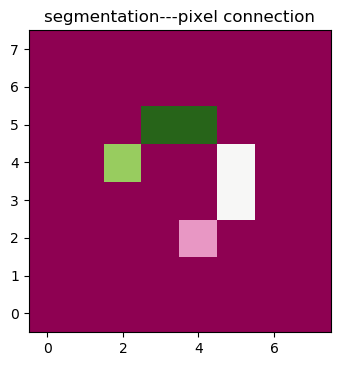

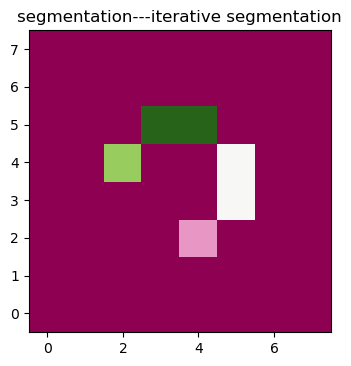

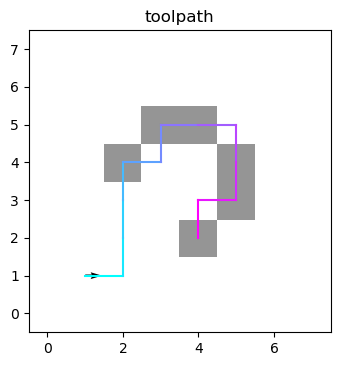

pic: 0  path length:  12.0


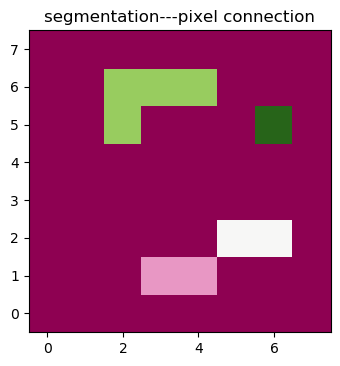

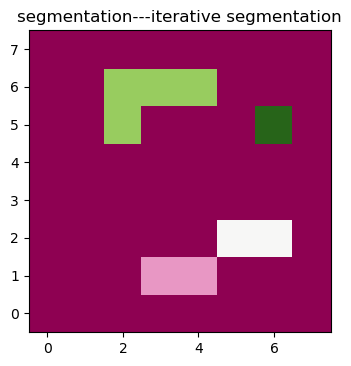

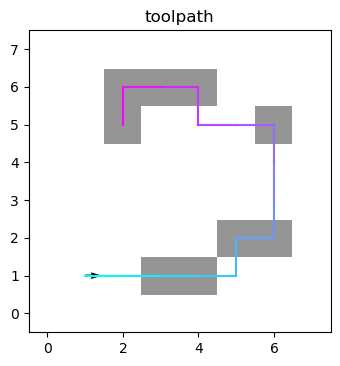

pic: 1  path length:  15.0


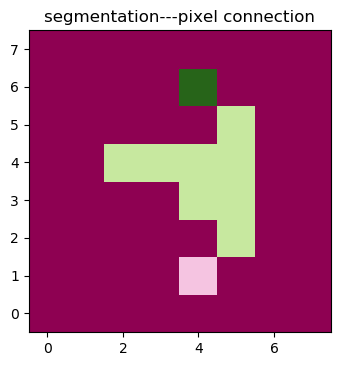

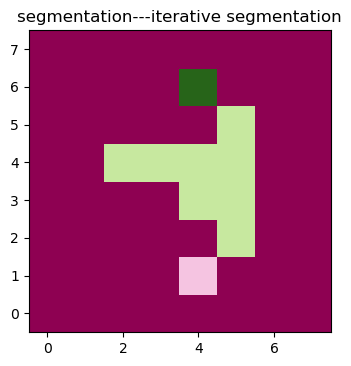

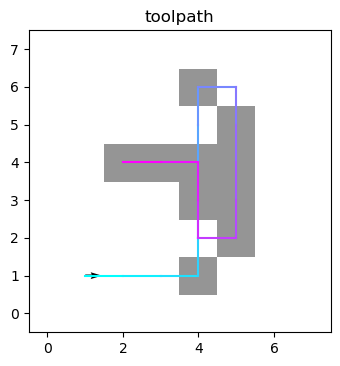

pic: 2  path length:  18.0


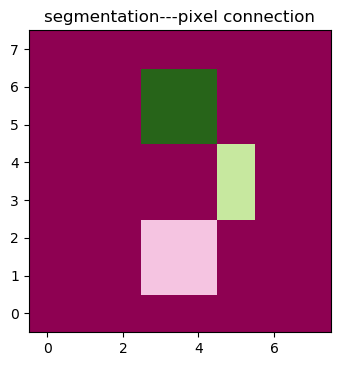

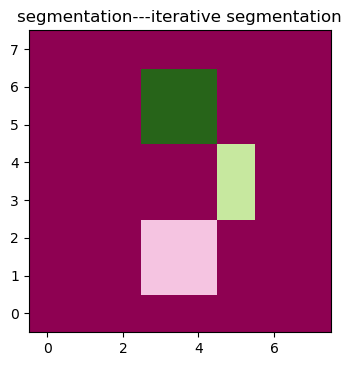

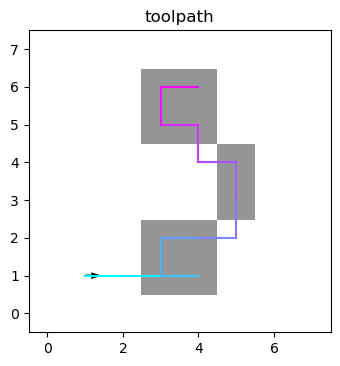

pic: 3  path length:  14.0


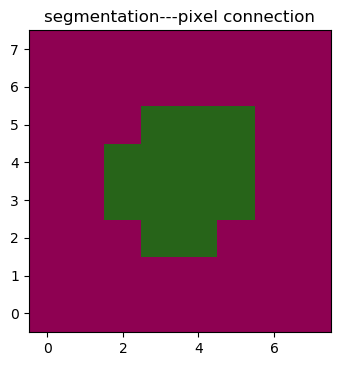

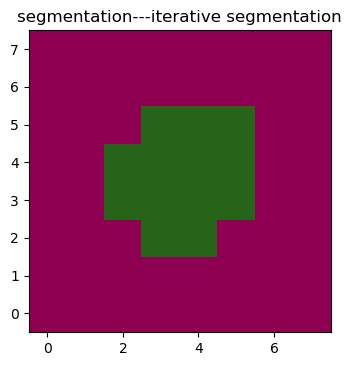

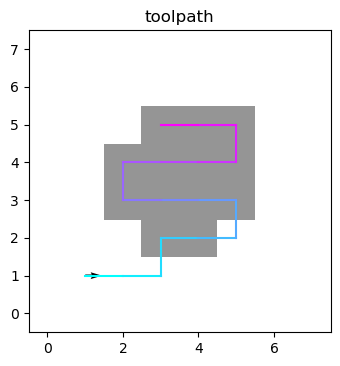

pic: 4  path length:  16.0


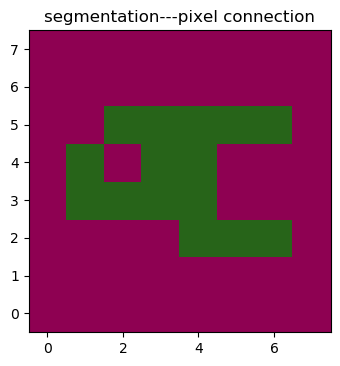

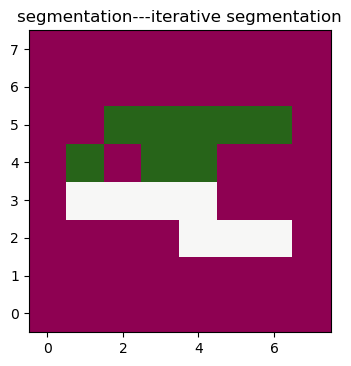

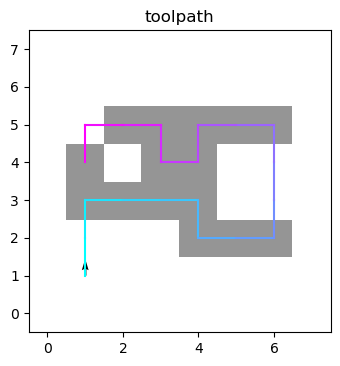

pic: 5  path length:  19.0


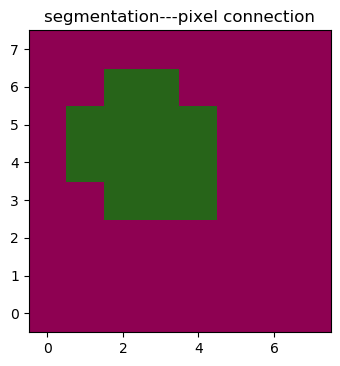

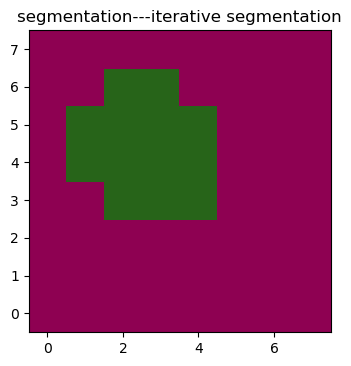

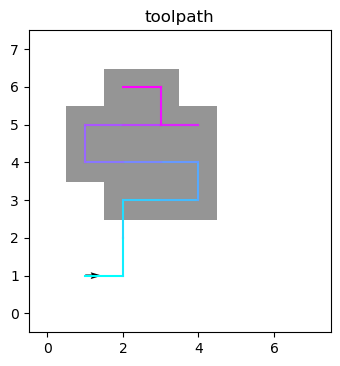

pic: 6  path length:  16.0


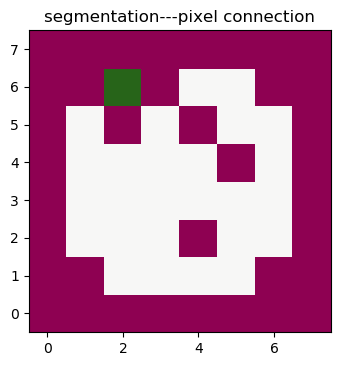

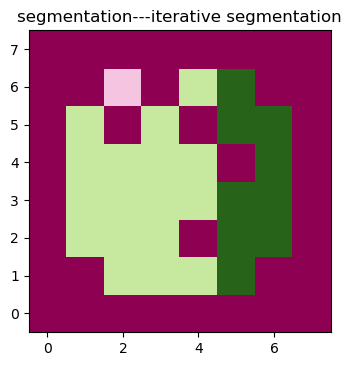

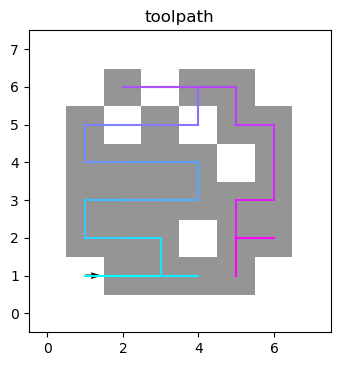

pic: 7  path length:  34.0


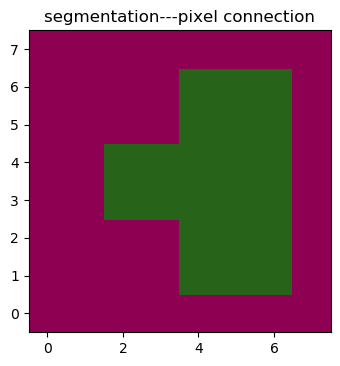

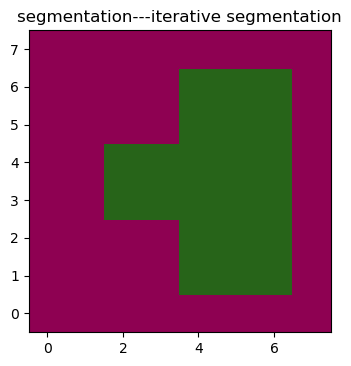

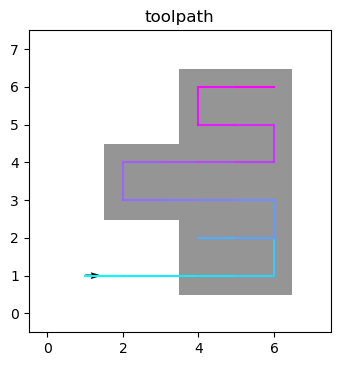

pic: 8  path length:  26.0


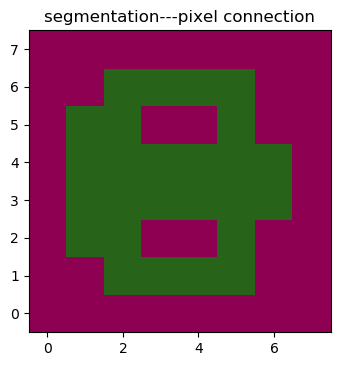

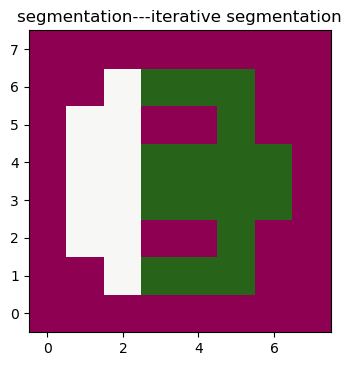

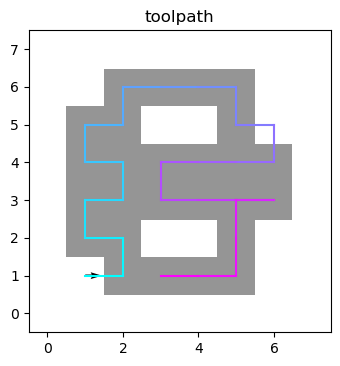

pic: 9  path length:  28.0
average path length in test dataset:  19.8


In [3]:
sections = load_sections('Sections/Database_8x8_v2/Report/')
initial_point = [1,1] # initial position of the path
PL = []
for section_id in range(10):
    section = sections[section_id][:,:,0] 
    pt = time.time()
    area_set = divide_image(section,show = True, pic_name = 'segmentation---pixel connection')
    tf = partial(ga_tsp_path_mi,section = section, area_set = area_set, initial_point = initial_point)
    gaaa = GA_path_m(tf,20,[len(area_set),8],crossover_rate=0.9, mutation_rate = 0.1)
    max_value, max_value_his, max_pop, max_prop = gaaa.iteration(20, 3, False)

#     fig,ax = plt.subplots()
#     ax.plot(np.arange(len(max_value_his))+1, max_value_his)
    path_length = -max_value

    [path_set, area_set], path_order = max_prop
    divided_section = np.zeros(shape = (section.shape[0],section.shape[1]))

    for i in range(len(area_set)):
        for j in range(len(area_set[i])):
            divided_section[area_set[i][j][0],area_set[i][j][1]] = i+1

    plot_image(divided_section, cmap_name='PiYG', pic_name = 'segmentation---iterative segmentation')


    def action_from_pos(pp, cp):
        if abs(pp[0]-cp[0])+abs(pp[1]-cp[1]) >1:
            print('H distance between two points is larger than 1.')
            return -1
        if cp[0]-pp[0] == -1:
            return 3
        if cp[0] - pp[0] == 1:
            return 2
        if cp[1]-pp[1] == -1:
            return 1
        if cp[1] - pp[1] == 1:
            return 0
        return [pp,cp]

    T_path = [[],[]]
    action_his = []
    for i in path_order:
        if i == 0:
            T_path[0].extend([initial_point[0]])
            T_path[1].extend([initial_point[1]])
        else:
            for j in range(len(path_set[i-1][0])):
                t_path_x = np.linspace(T_path[0][-1], path_set[i-1][0][j], int(abs(path_set[i-1][0][j] - T_path[0][-1])+1))
                t_path_y = np.linspace(T_path[1][-1], path_set[i-1][1][j], int(abs(path_set[i-1][1][j] - T_path[1][-1])+1))
                for tx in t_path_x[1:]:
                    T_path[0].append(round(tx))
                    T_path[1].append(T_path[1][-1])
                    action_his.append(action_from_pos([T_path[0][-2], T_path[1][-2]],[T_path[0][-1], T_path[1][-1]]))
                for ty in t_path_y[1:]:
                    T_path[0].append(T_path[0][-1])
                    T_path[1].append(round(ty))
                    action_his.append(action_from_pos([T_path[0][-2], T_path[1][-2]],[T_path[0][-1], T_path[1][-1]]))

    plot_image(section,[T_path],cv_map=[0,2], pic_name = 'toolpath')

    path_point = T_path
    print('pic: '+str(section_id) + '  path length: ',path_length)
    PL.append(path_length)
    
print('average path length in test dataset: ',np.mean(PL) )

### Numerical Segmentation
#### test in 8x8 dataset

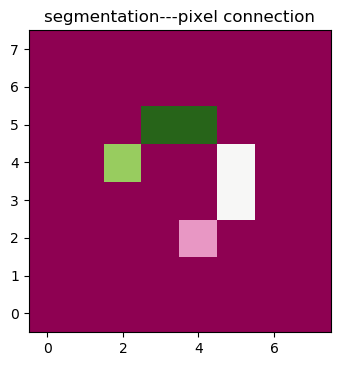

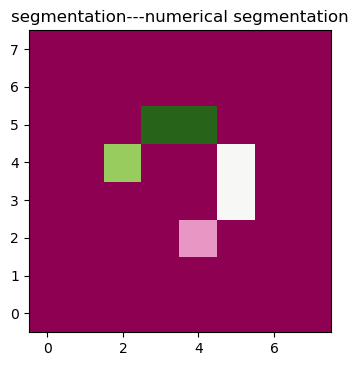

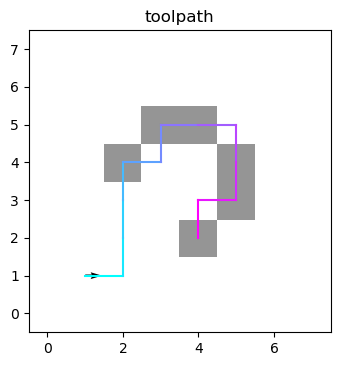

pic: 0  path length:  12.0


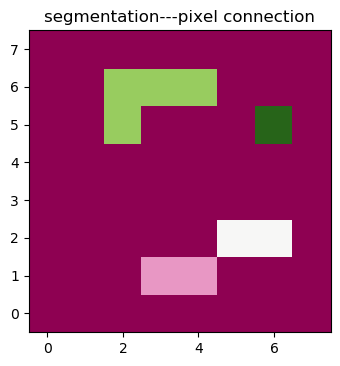

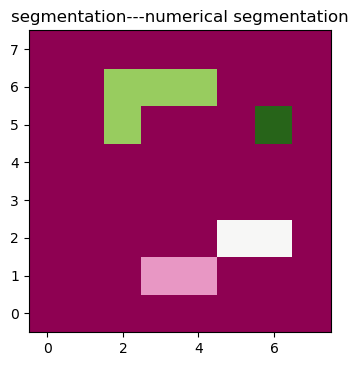

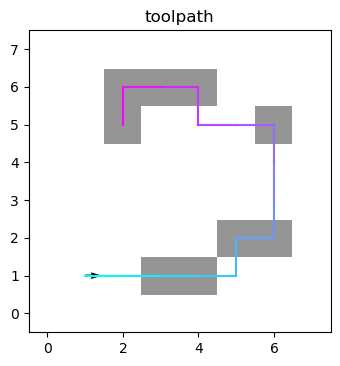

pic: 1  path length:  15.0


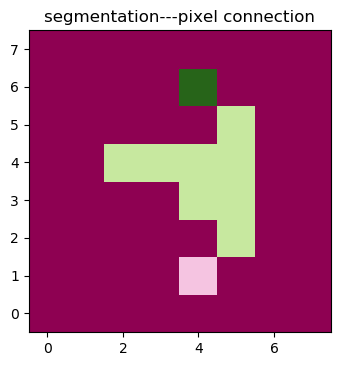

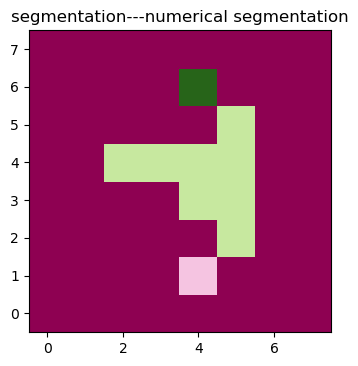

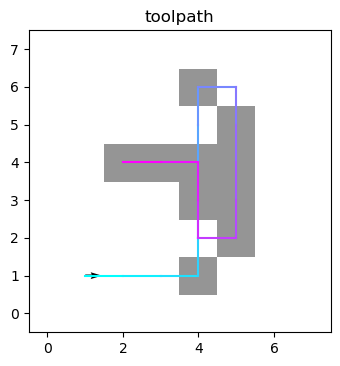

pic: 2  path length:  18.0


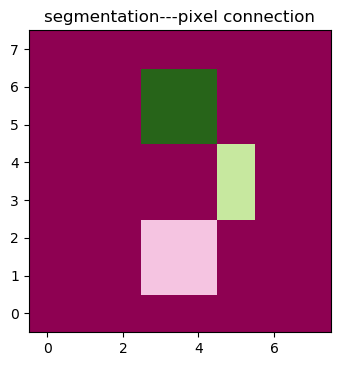

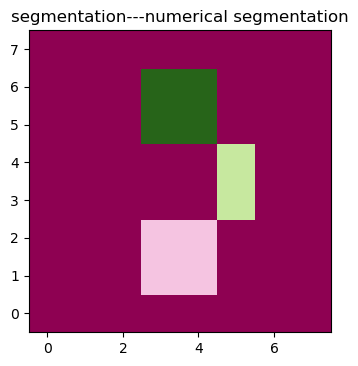

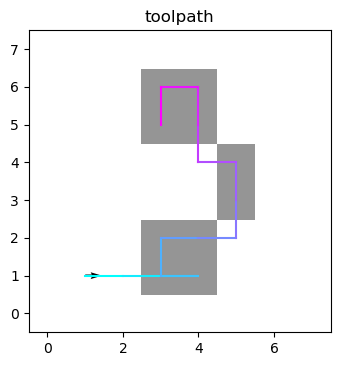

pic: 3  path length:  14.0


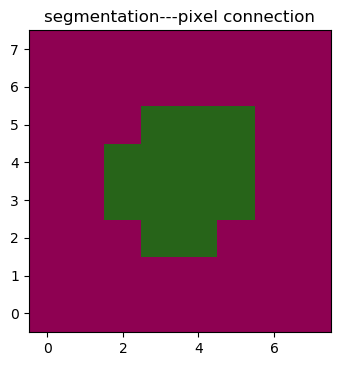

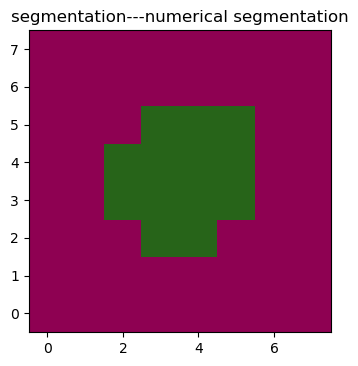

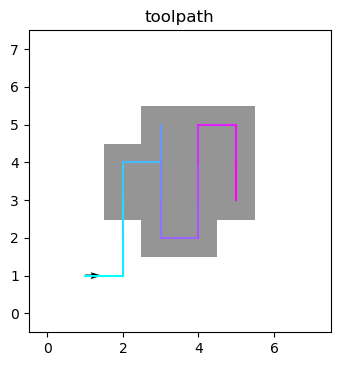

pic: 4  path length:  16.0


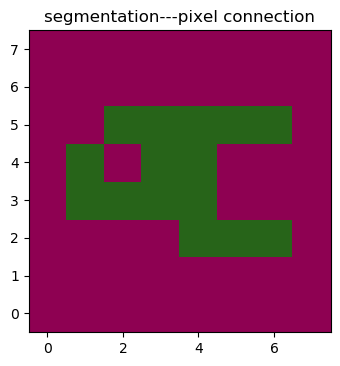

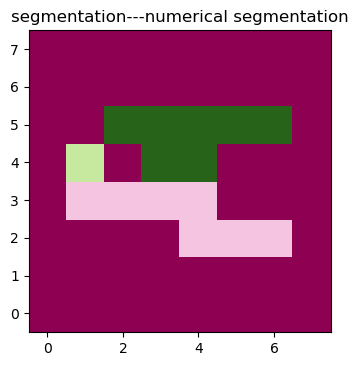

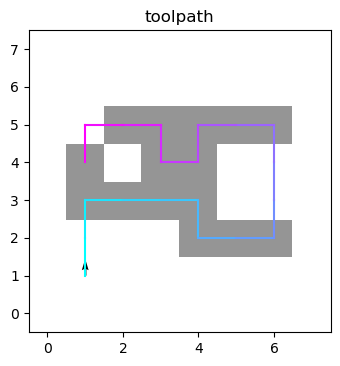

pic: 5  path length:  19.0


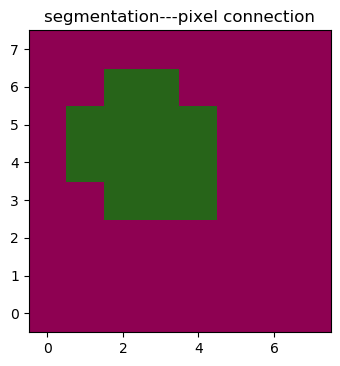

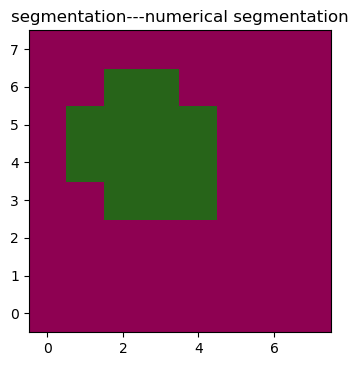

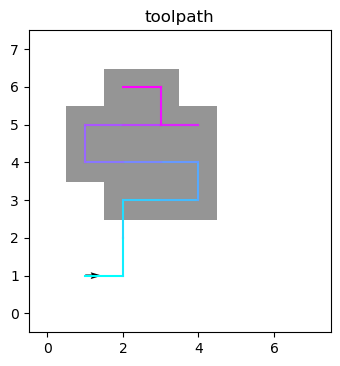

pic: 6  path length:  16.0


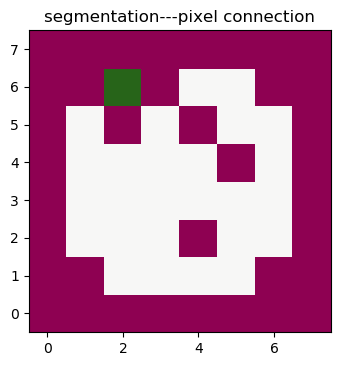

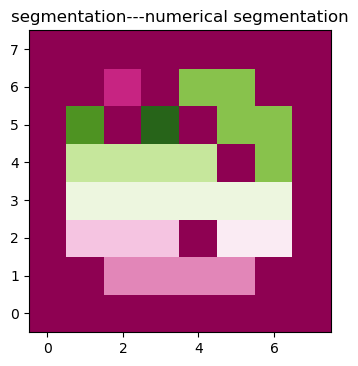

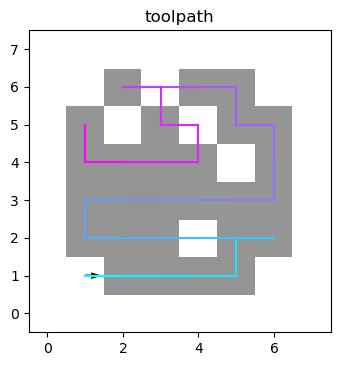

pic: 7  path length:  32.0


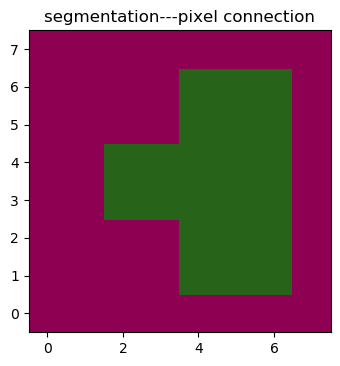

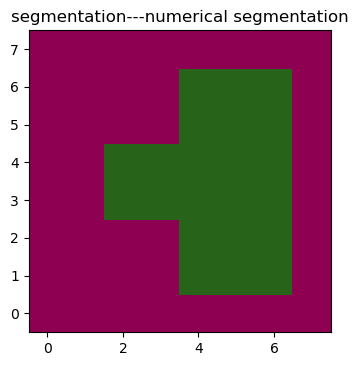

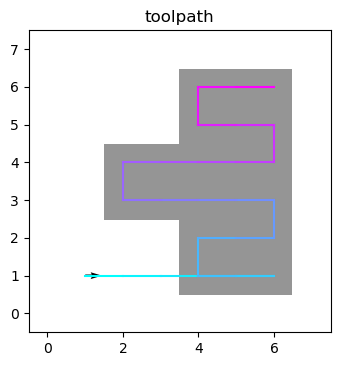

pic: 8  path length:  26.0


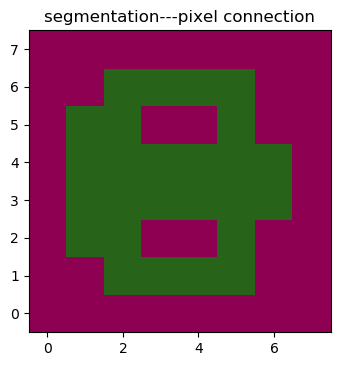

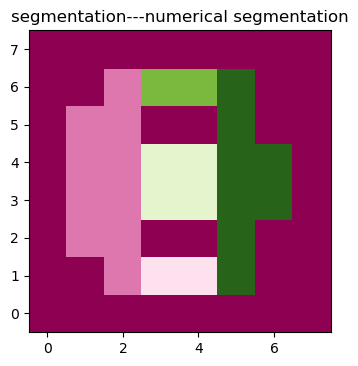

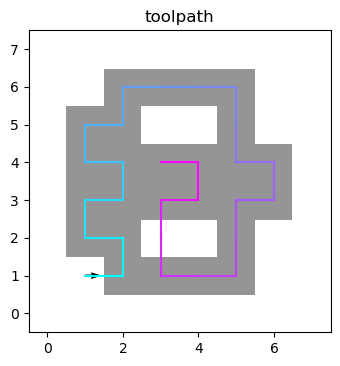

pic: 9  path length:  27.0
average path length in test dataset:  19.5


In [4]:
sections = load_sections('Sections/Database_8x8_v2/Report/')
initial_point = [1,1] # initial position of the path
PL = []
for section_id in range(10):
    section = sections[section_id][:,:,0] 
    pt = time.time()
    area_set = divide_image(section,show = True, pic_name = 'segmentation---pixel connection')
    tf = partial(ga_tsp_path_mn,section = section, area_set = area_set, initial_point = initial_point)
    gaaa = GA_path_m(tf,20,[len(area_set),8],crossover_rate=0.9, mutation_rate = 0.1)
    max_value, max_value_his, max_pop, max_prop = gaaa.iteration(20, 3, False)

#     fig,ax = plt.subplots()
#     ax.plot(np.arange(len(max_value_his))+1, max_value_his)
    path_length = -max_value

    [path_set, area_set], path_order = max_prop
    divided_section = np.zeros(shape = (section.shape[0],section.shape[1]))

    for i in range(len(area_set)):
        for j in range(len(area_set[i])):
            divided_section[area_set[i][j][0],area_set[i][j][1]] = i+1

    plot_image(divided_section, cmap_name='PiYG', pic_name = 'segmentation---numerical segmentation')


    def action_from_pos(pp, cp):
        if abs(pp[0]-cp[0])+abs(pp[1]-cp[1]) >1:
            print('H distance between two points is larger than 1.')
            return -1
        if cp[0]-pp[0] == -1:
            return 3
        if cp[0] - pp[0] == 1:
            return 2
        if cp[1]-pp[1] == -1:
            return 1
        if cp[1] - pp[1] == 1:
            return 0
        return [pp,cp]

    T_path = [[],[]]
    action_his = []
    for i in path_order:
        if i == 0:
            T_path[0].extend([initial_point[0]])
            T_path[1].extend([initial_point[1]])
        else:
            for j in range(len(path_set[i-1][0])):
                t_path_x = np.linspace(T_path[0][-1], path_set[i-1][0][j], int(abs(path_set[i-1][0][j] - T_path[0][-1])+1))
                t_path_y = np.linspace(T_path[1][-1], path_set[i-1][1][j], int(abs(path_set[i-1][1][j] - T_path[1][-1])+1))
                for tx in t_path_x[1:]:
                    T_path[0].append(round(tx))
                    T_path[1].append(T_path[1][-1])
                    action_his.append(action_from_pos([T_path[0][-2], T_path[1][-2]],[T_path[0][-1], T_path[1][-1]]))
                for ty in t_path_y[1:]:
                    T_path[0].append(T_path[0][-1])
                    T_path[1].append(round(ty))
                    action_his.append(action_from_pos([T_path[0][-2], T_path[1][-2]],[T_path[0][-1], T_path[1][-1]]))

    plot_image(section,[T_path],cv_map=[0,2], pic_name = 'toolpath')

    path_point = T_path
    print('pic: '+str(section_id) + '  path length: ',path_length)
    PL.append(path_length)
    
print('average path length in test dataset: ',np.mean(PL) )

#### test in 16x16 dataset

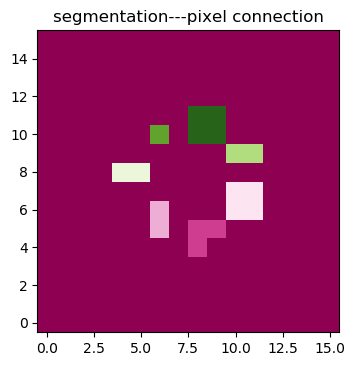

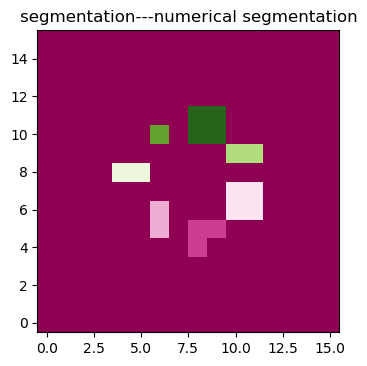

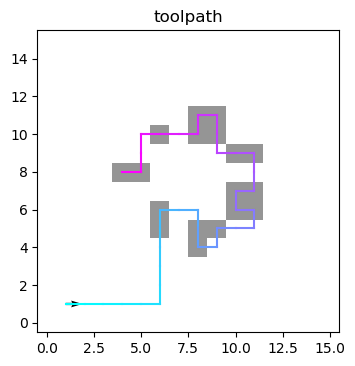

pic: 0  path length:  36.0


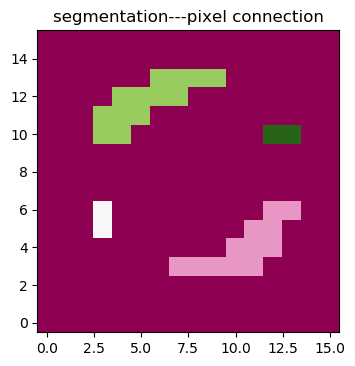

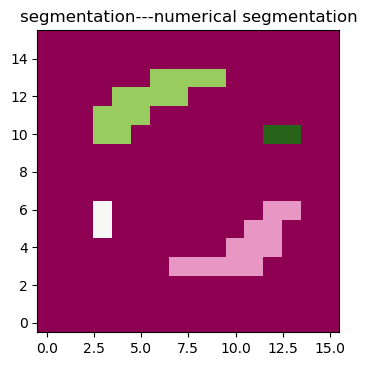

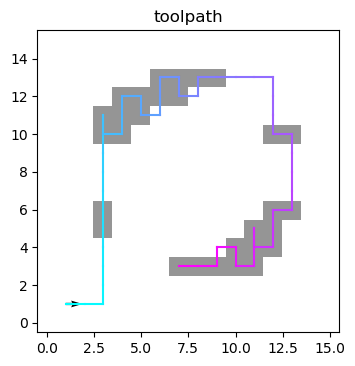

pic: 1  path length:  50.0


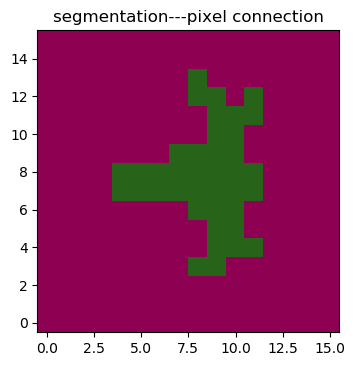

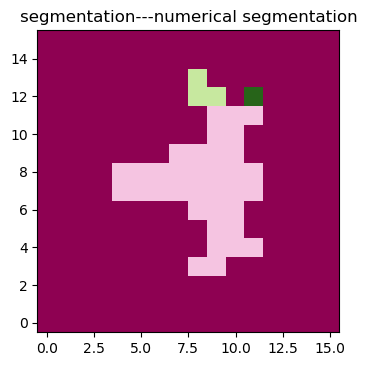

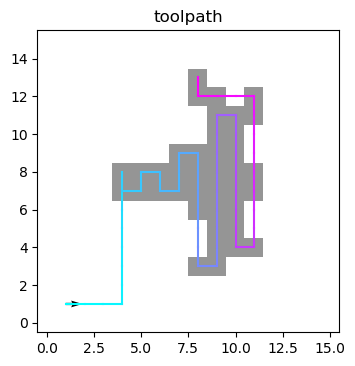

pic: 2  path length:  55.0


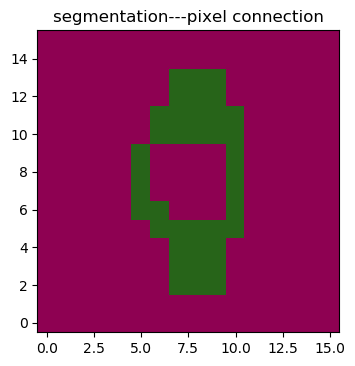

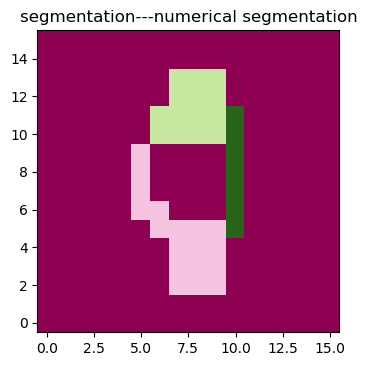

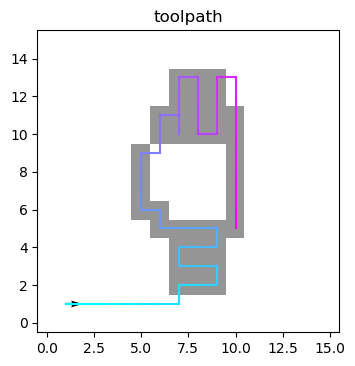

pic: 3  path length:  49.0


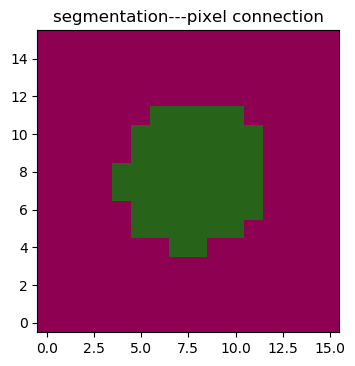

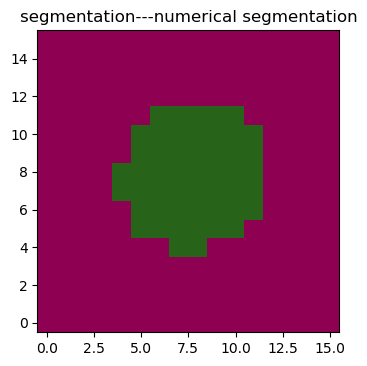

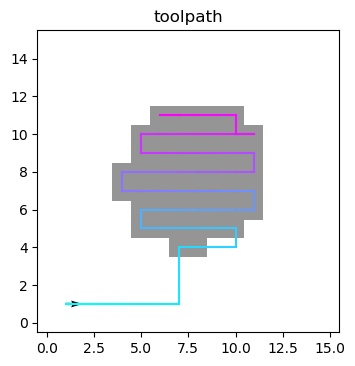

pic: 4  path length:  61.0


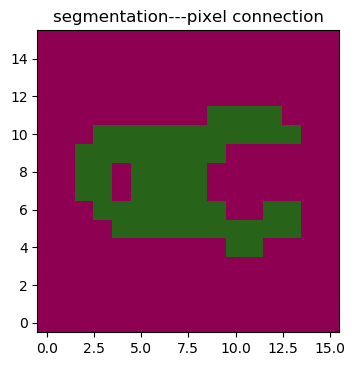

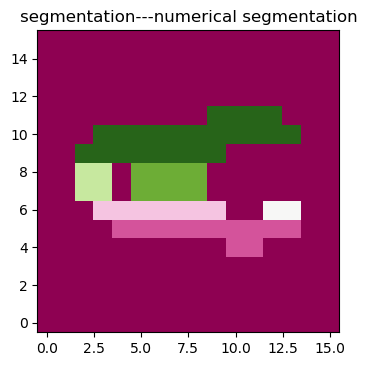

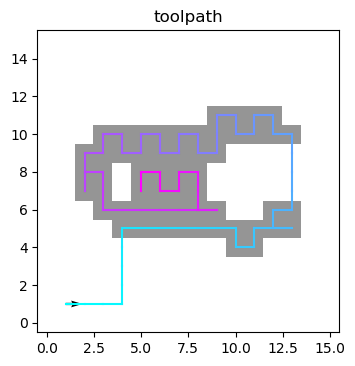

pic: 5  path length:  68.0


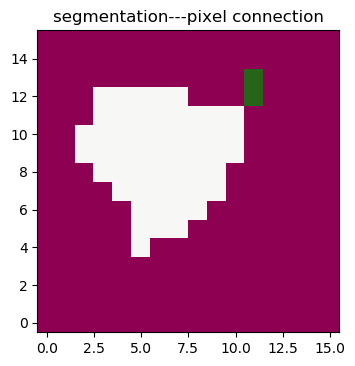

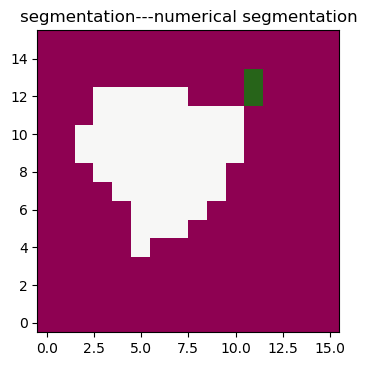

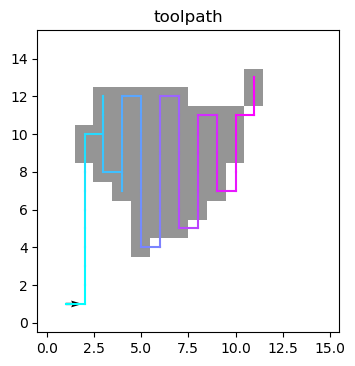

pic: 6  path length:  70.0


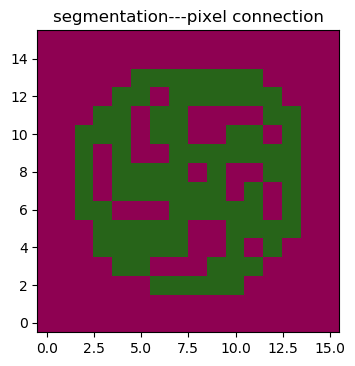

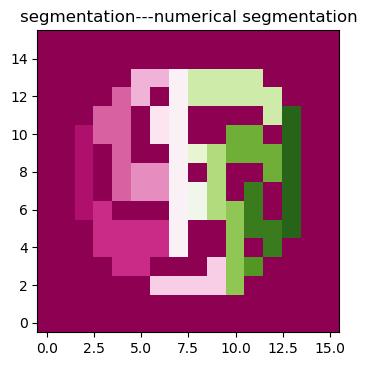

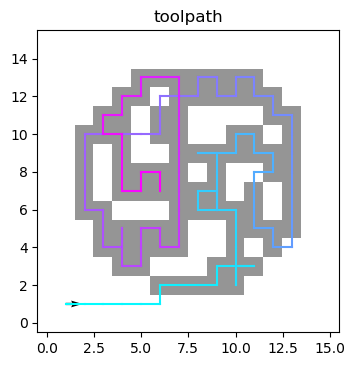

pic: 7  path length:  107.0


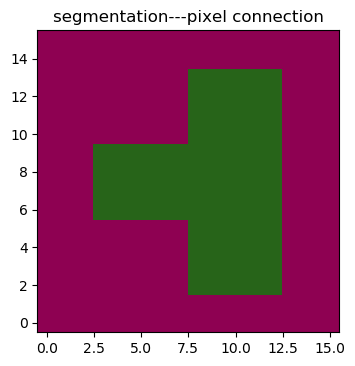

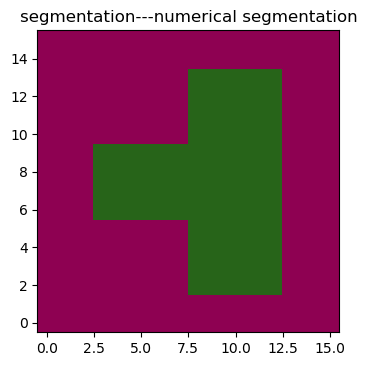

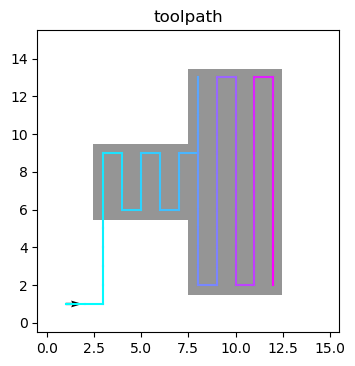

pic: 8  path length:  90.0


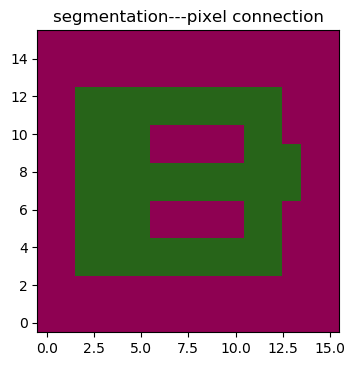

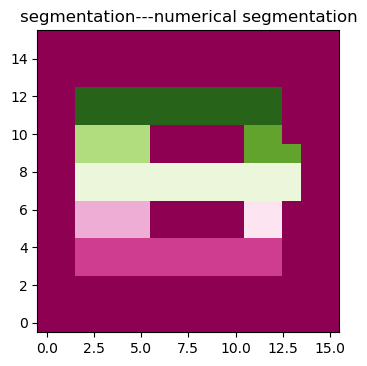

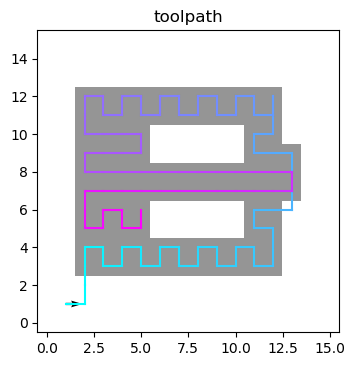

pic: 9  path length:  99.0
average path length in test dataset:  68.5


In [5]:
sections = load_sections('Sections/Database_16x16_v2/Report/')
initial_point = [1,1] # initial position of the path
PL = []
for section_id in range(10):
    section = sections[section_id][:,:,0] 
    pt = time.time()
    area_set = divide_image(section,show = True, pic_name = 'segmentation---pixel connection')
    tf = partial(ga_tsp_path_mn,section = section, area_set = area_set, initial_point = initial_point)
    gaaa = GA_path_m(tf,20,[len(area_set),8],crossover_rate=0.9, mutation_rate = 0.1)
    max_value, max_value_his, max_pop, max_prop = gaaa.iteration(20, 3, False)

#     fig,ax = plt.subplots()
#     ax.plot(np.arange(len(max_value_his))+1, max_value_his)
    path_length = -max_value

    [path_set, area_set], path_order = max_prop
    divided_section = np.zeros(shape = (section.shape[0],section.shape[1]))

    for i in range(len(area_set)):
        for j in range(len(area_set[i])):
            divided_section[area_set[i][j][0],area_set[i][j][1]] = i+1

    plot_image(divided_section, cmap_name='PiYG', pic_name = 'segmentation---numerical segmentation')


    def action_from_pos(pp, cp):
        if abs(pp[0]-cp[0])+abs(pp[1]-cp[1]) >1:
            print('H distance between two points is larger than 1.')
            return -1
        if cp[0]-pp[0] == -1:
            return 3
        if cp[0] - pp[0] == 1:
            return 2
        if cp[1]-pp[1] == -1:
            return 1
        if cp[1] - pp[1] == 1:
            return 0
        return [pp,cp]

    T_path = [[],[]]
    action_his = []
    for i in path_order:
        if i == 0:
            T_path[0].extend([initial_point[0]])
            T_path[1].extend([initial_point[1]])
        else:
            for j in range(len(path_set[i-1][0])):
                t_path_x = np.linspace(T_path[0][-1], path_set[i-1][0][j], int(abs(path_set[i-1][0][j] - T_path[0][-1])+1))
                t_path_y = np.linspace(T_path[1][-1], path_set[i-1][1][j], int(abs(path_set[i-1][1][j] - T_path[1][-1])+1))
                for tx in t_path_x[1:]:
                    T_path[0].append(round(tx))
                    T_path[1].append(T_path[1][-1])
                    action_his.append(action_from_pos([T_path[0][-2], T_path[1][-2]],[T_path[0][-1], T_path[1][-1]]))
                for ty in t_path_y[1:]:
                    T_path[0].append(T_path[0][-1])
                    T_path[1].append(round(ty))
                    action_his.append(action_from_pos([T_path[0][-2], T_path[1][-2]],[T_path[0][-1], T_path[1][-1]]))

    plot_image(section,[T_path],cv_map=[0,2], pic_name = 'toolpath')

    path_point = T_path
    print('pic: '+str(section_id) + '  path length: ',path_length)
    PL.append(path_length)
    
print('average path length in test dataset: ',np.mean(PL) )

#### several examples in 32x32 dataset

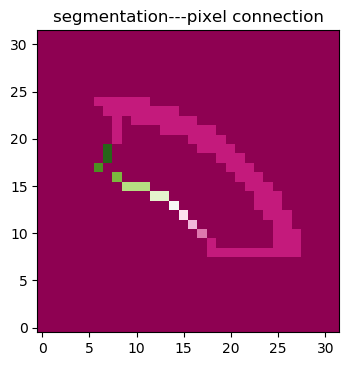

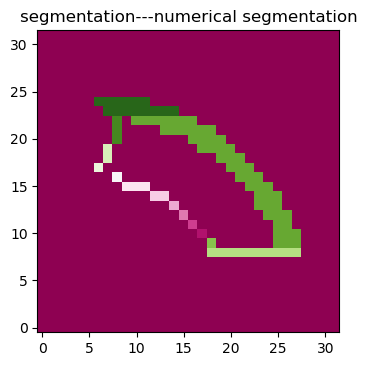

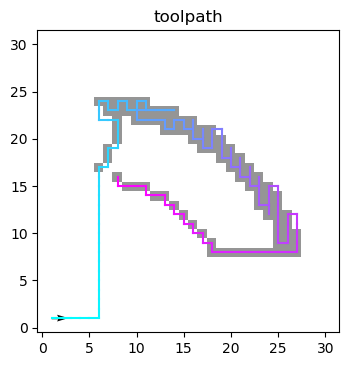

pic: 17  path length:  138.0


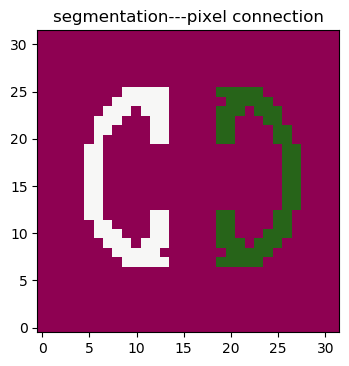

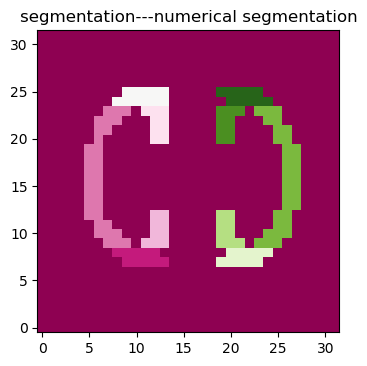

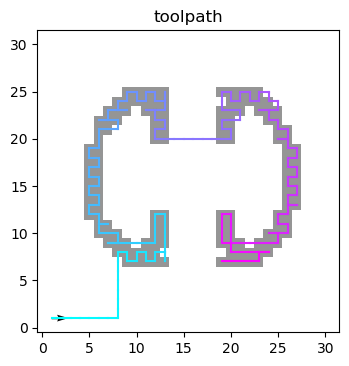

pic: 39  path length:  182.0


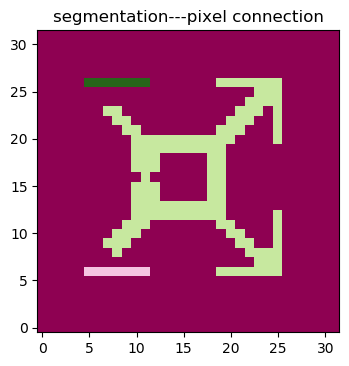

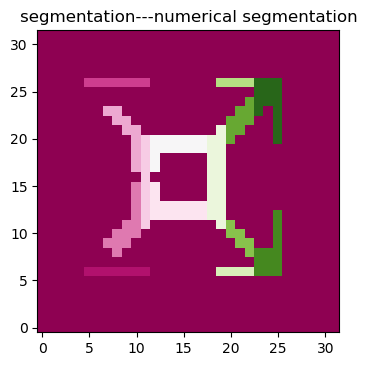

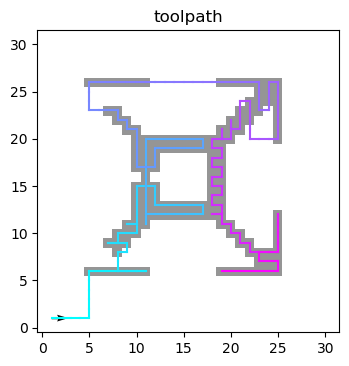

pic: 67  path length:  189.0


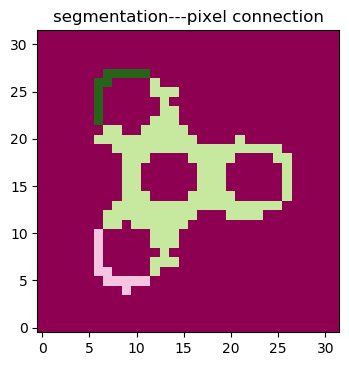

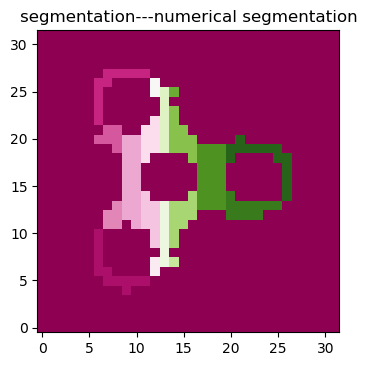

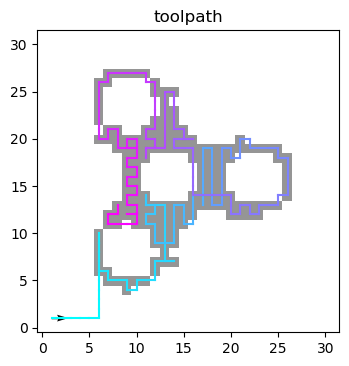

pic: 91  path length:  201.0


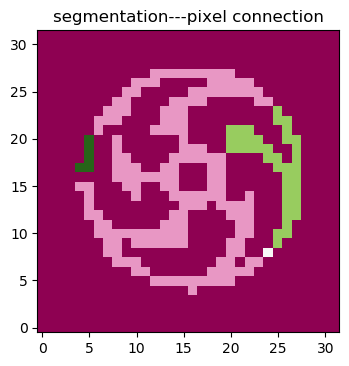

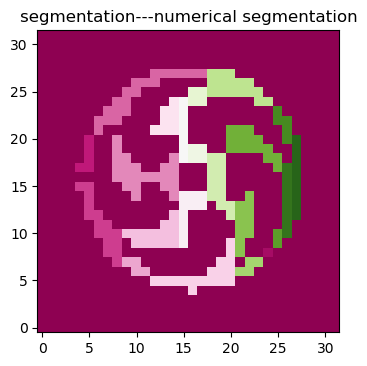

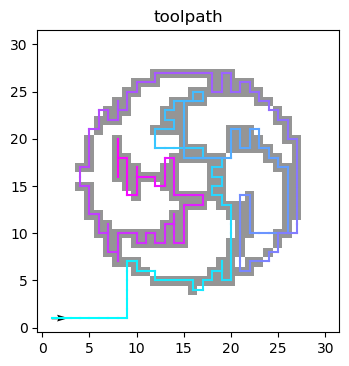

pic: 164  path length:  272.0


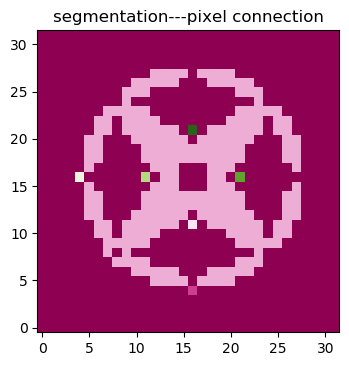

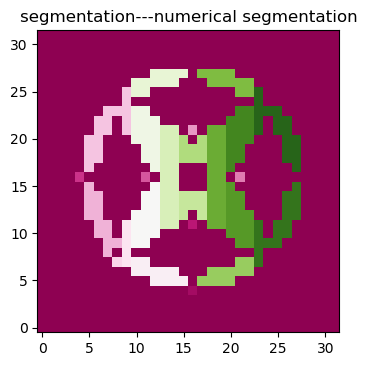

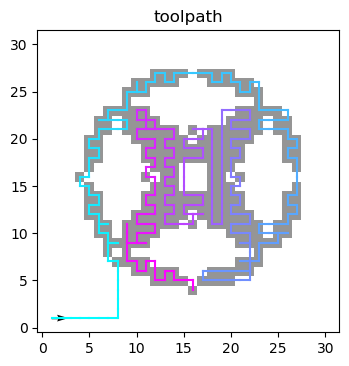

pic: 213  path length:  310.0
average path length in test dataset:  215.33333333333334


In [6]:
sections = load_sections('Sections/Database_32x32_v2/')
example_ids = [17,39,67, 91,164,213]
initial_point = [1,1] # initial position of the path
PL = []
for section_id in example_ids:
    section = sections[section_id][:,:,0] 
    pt = time.time()
    area_set = divide_image(section,show = True, pic_name = 'segmentation---pixel connection')
    tf = partial(ga_tsp_path_mn,section = section, area_set = area_set, initial_point = initial_point)
    gaaa = GA_path_m(tf,20,[len(area_set),8],crossover_rate=0.9, mutation_rate = 0.1)
    max_value, max_value_his, max_pop, max_prop = gaaa.iteration(20, 3, False)

#     fig,ax = plt.subplots()
#     ax.plot(np.arange(len(max_value_his))+1, max_value_his)
    path_length = -max_value

    [path_set, area_set], path_order = max_prop
    divided_section = np.zeros(shape = (section.shape[0],section.shape[1]))

    for i in range(len(area_set)):
        for j in range(len(area_set[i])):
            divided_section[area_set[i][j][0],area_set[i][j][1]] = i+1

    plot_image(divided_section, cmap_name='PiYG', pic_name = 'segmentation---numerical segmentation')


    def action_from_pos(pp, cp):
        if abs(pp[0]-cp[0])+abs(pp[1]-cp[1]) >1:
            print('H distance between two points is larger than 1.')
            return -1
        if cp[0]-pp[0] == -1:
            return 3
        if cp[0] - pp[0] == 1:
            return 2
        if cp[1]-pp[1] == -1:
            return 1
        if cp[1] - pp[1] == 1:
            return 0
        return [pp,cp]

    T_path = [[],[]]
    action_his = []
    for i in path_order:
        if i == 0:
            T_path[0].extend([initial_point[0]])
            T_path[1].extend([initial_point[1]])
        else:
            for j in range(len(path_set[i-1][0])):
                t_path_x = np.linspace(T_path[0][-1], path_set[i-1][0][j], int(abs(path_set[i-1][0][j] - T_path[0][-1])+1))
                t_path_y = np.linspace(T_path[1][-1], path_set[i-1][1][j], int(abs(path_set[i-1][1][j] - T_path[1][-1])+1))
                for tx in t_path_x[1:]:
                    T_path[0].append(round(tx))
                    T_path[1].append(T_path[1][-1])
                    action_his.append(action_from_pos([T_path[0][-2], T_path[1][-2]],[T_path[0][-1], T_path[1][-1]]))
                for ty in t_path_y[1:]:
                    T_path[0].append(T_path[0][-1])
                    T_path[1].append(round(ty))
                    action_his.append(action_from_pos([T_path[0][-2], T_path[1][-2]],[T_path[0][-1], T_path[1][-1]]))

    plot_image(section,[T_path],cv_map=[0,2], pic_name = 'toolpath')

    path_point = T_path
    print('pic: '+str(section_id) + '  path length: ',path_length)
    PL.append(path_length)
    
print('average path length in test dataset: ',np.mean(PL) )